Notebook Color Schemes:


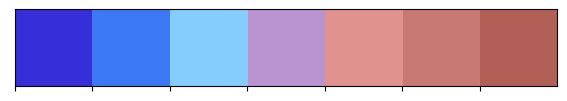

In [1]:
import os
import cv2
import wandb
import random
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[38;5;4m'
    E = '\033[0m'
    
colors = ["#362FD9", "#3C79F5", "#85CDFD", "#BA94D1", 
             "#DF928E", "#C97973", "#B25F57"]

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(colors))
plt.show()

In [2]:
# Log in to your W&B account
wandb.login()

True

In [3]:
# === General Functions ===
        
# === W&B ===
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [4]:
train = pd.read_csv("../data/train.csv")
train.head()

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [5]:
base_path = "/Users/dodam/Desktop/Project/data/RSNABreastCancer/"

all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + '_' + str(row.image_id) + ".png")
    
train["path"] = all_paths

100%|████████████████████████████████████| 54706/54706 [00:02<00:00, 27083.40it/s]


In [6]:
print(clr.S+"Number of TOTAL images:"+clr.E,
      len(glob("../data/RSNABreastCancer/*")))
print(clr.S+"Records gathered in Site 1:"+clr.E, train["site_id"].value_counts().values[0], "\n"+
      clr.S+"Records gathered in Site 2:"+clr.E, train["site_id"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Total unique patients:"+clr.E, train["patient_id"].nunique())
print("-------------------------------------------------")
print(clr.S+"Statistics: Images per Patient"+clr.E)
print(train.groupby("patient_id")["image_id"].count().reset_index().describe()["image_id"])
print("-------------------------------------------------")
print(clr.S+"Image records count per laterality (R):"+clr.E, train["laterality"].value_counts().values[0], "\n"+
      clr.S+"Image records count per laterality (L):"+clr.E, train["laterality"].value_counts().values[1])
print("-------------------------------------------------")
print(clr.S+"Image records count per View:"+clr.E)
print(train["view"].value_counts())

Number of TOTAL images: 54706
Records gathered in Site 1: 29519 
Records gathered in Site 2: 25187
-------------------------------------------------
Total unique patients: 11913
-------------------------------------------------
Statistics: Images per Patient
count    11913.000000
mean         4.592126
std          1.133216
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         14.000000
Name: image_id, dtype: float64
-------------------------------------------------
Image records count per laterality (R): 27439 
Image records count per laterality (L): 27267
-------------------------------------------------
Image records count per View:
MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64


`view` - The orientation of the image. The default for a screening exam is to capture two views per breast.
- MLO (Mediolateral Oblique): 내외사위촬영,중심-바깥 비스듬히
- CC (Craniocaudal): 상하촬영
- AT (Axillary Tail): 젖샘가쪽돌기, 젖샘 꼬리
- LM (Latero-Medial):측면-안쪽
- ML (Medio-Lateral): 중심-바깥쪽
- LMO (Latero-Medial oblique): 측면-안쪽 사방형

In [7]:
run = wandb.init(project='RSNA_Breast_Cancer', name='view', config=CONFIG)

In [8]:
def show_view(view_name, sample_size):
    
    if view_name != "LMO":
        data = train[train["view"]==view_name].sample(sample_size, random_state=24)
        img_path = data["path"].to_list()

        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []

        for k, path in enumerate(img_path):
            axs[k].set_title(f"{k+1}. {view_name}", 
                             fontsize = 16, color = colors[0], weight='bold')

            img = cv2.imread(path)
            wandb_images.append(wandb.Image(img))
            axs[k].imshow(img)
            axs[k].axis("off")

        plt.tight_layout()
        plt.show()

        wandb.log({f"{view_name}": wandb_images})
    else:
        path = train[train["view"]=="LMO"]["path"].item()
        # Plot
        fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
        axs = axs.flatten()
        wandb_images = []
        img = cv2.imread(path)
        wandb_images.append(wandb.Image(img))
        axs[0].imshow(img)
        axs[0].set_title(f"1. LMO", 
                         fontsize = 16, color = colors[0], weight='bold')
        axs[0].axis("off")
        axs[1].axis("off")
        axs[2].axis("off")
        axs[3].axis("off")
        axs[4].axis("off")

        plt.tight_layout()
        plt.show()
        
        wandb.log({f"LMO": wandb_images})

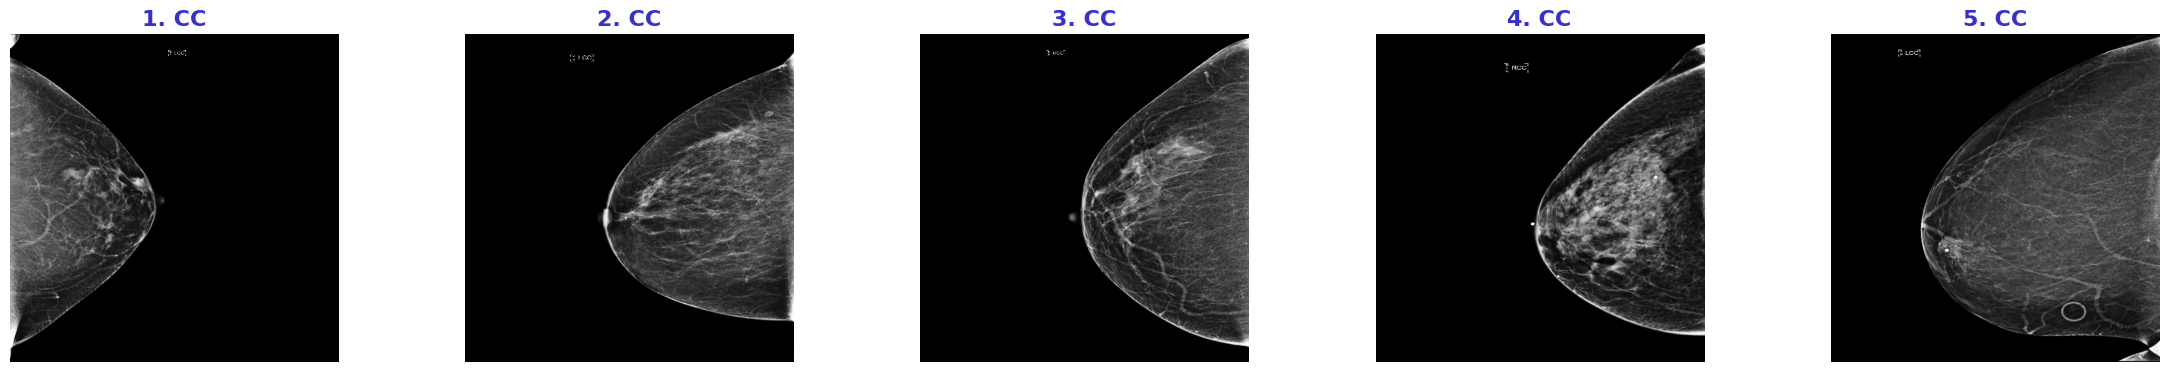

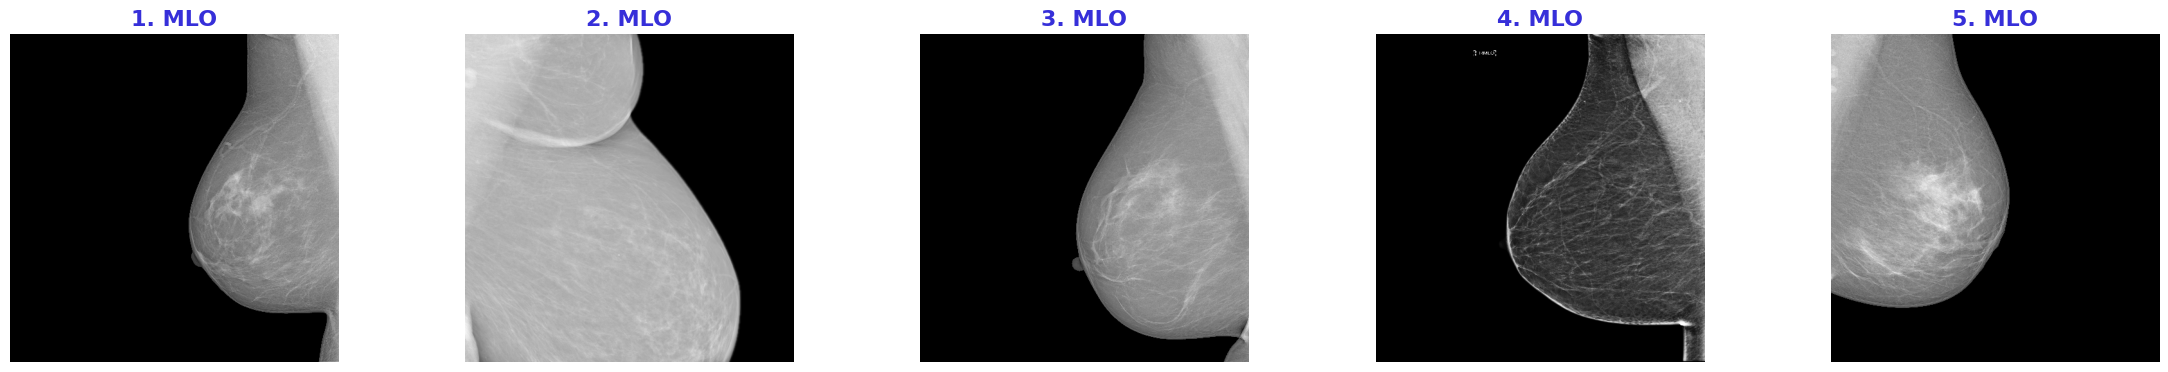

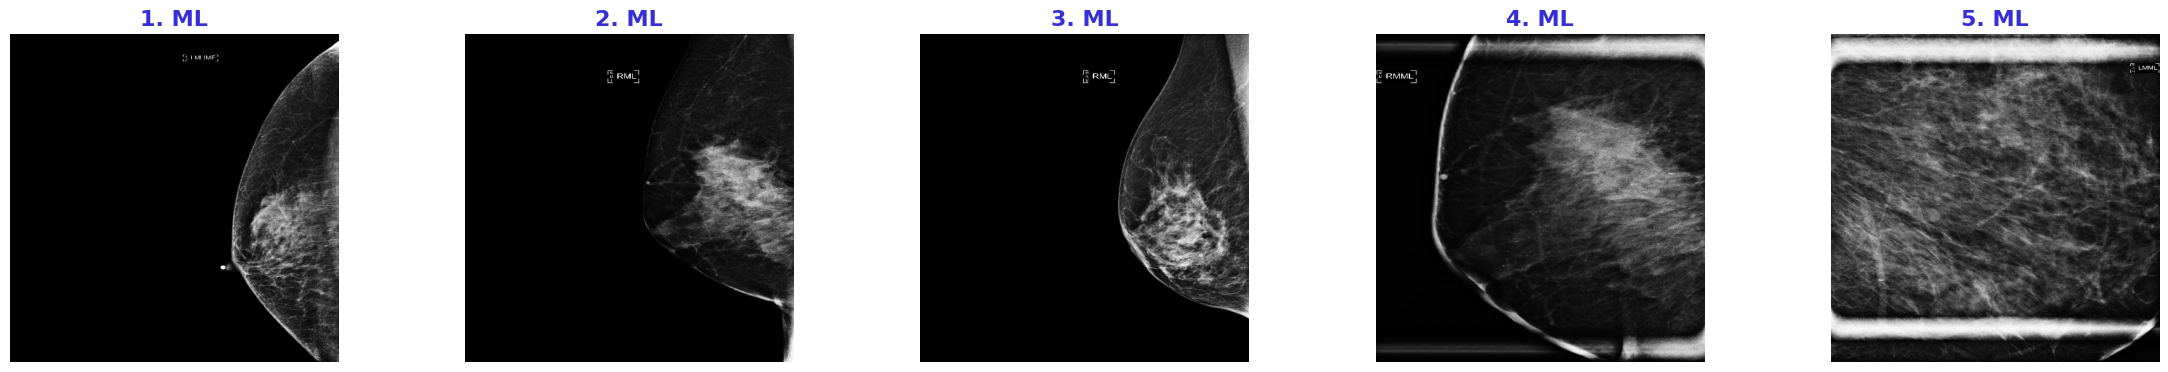

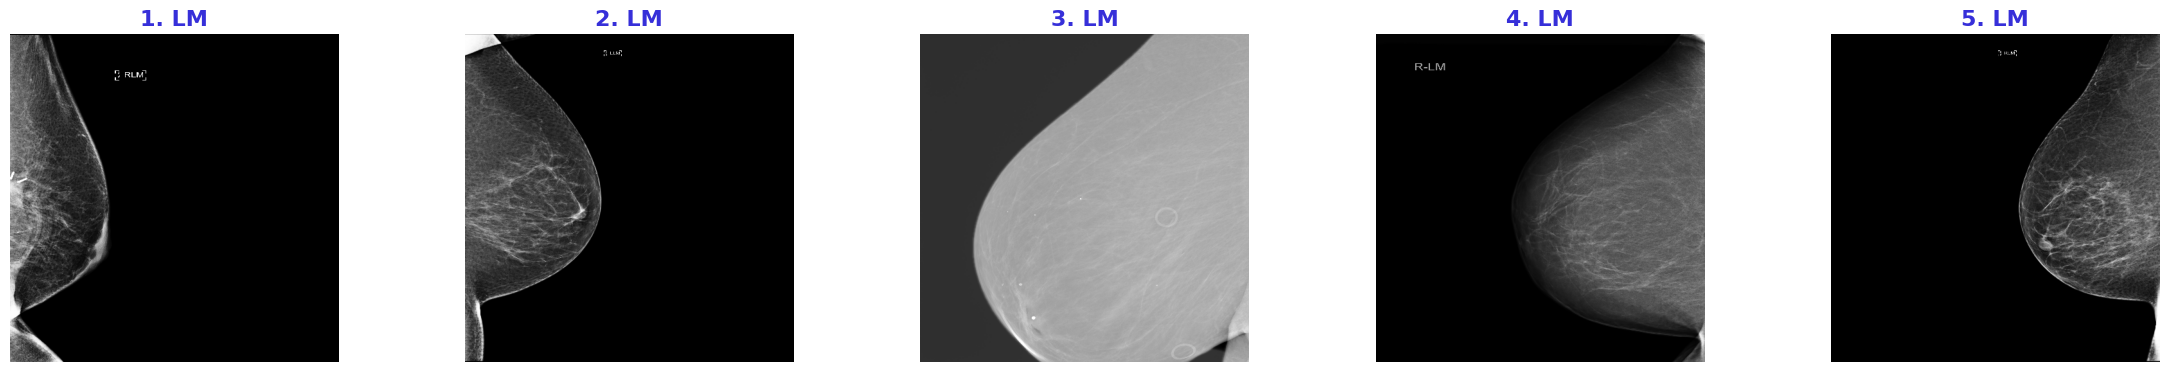

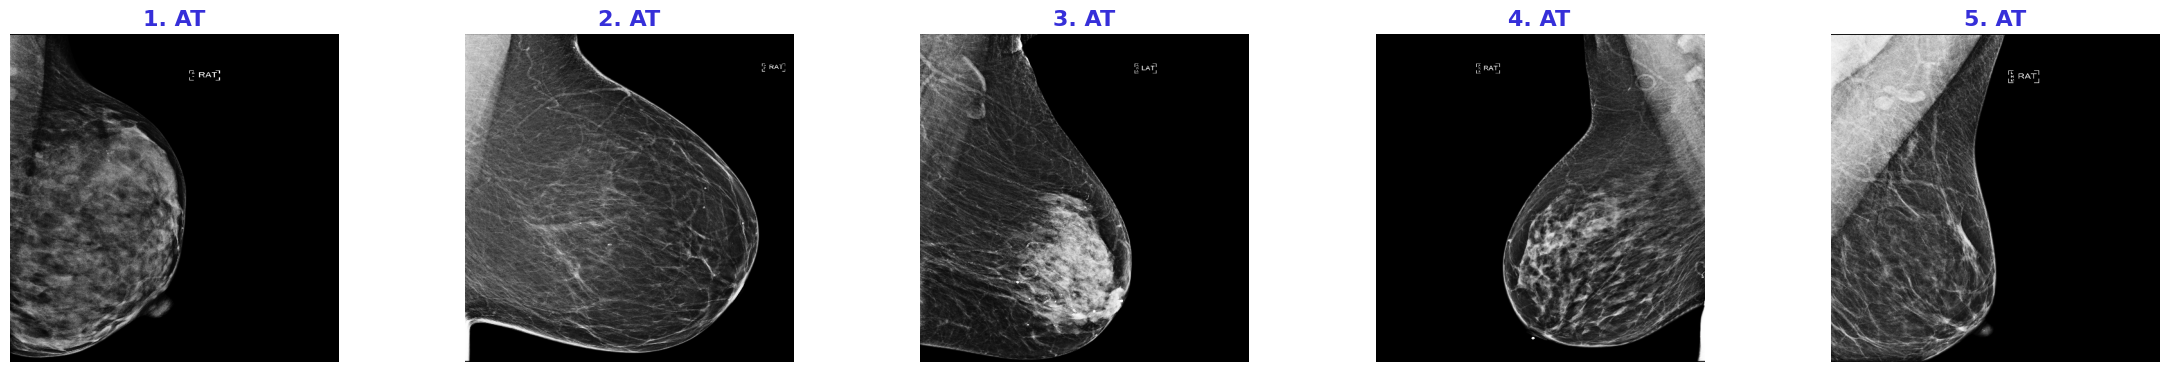

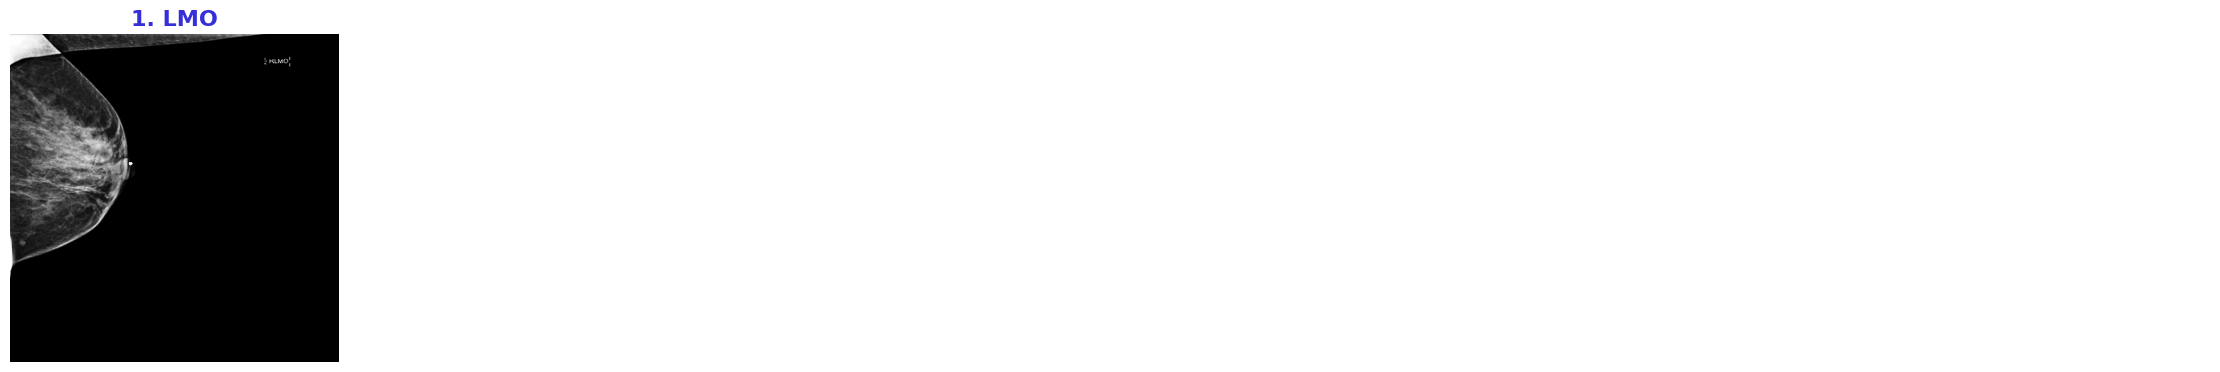

In [9]:
for view_name in train["view"].unique().tolist():
    show_view(view_name, sample_size=5)

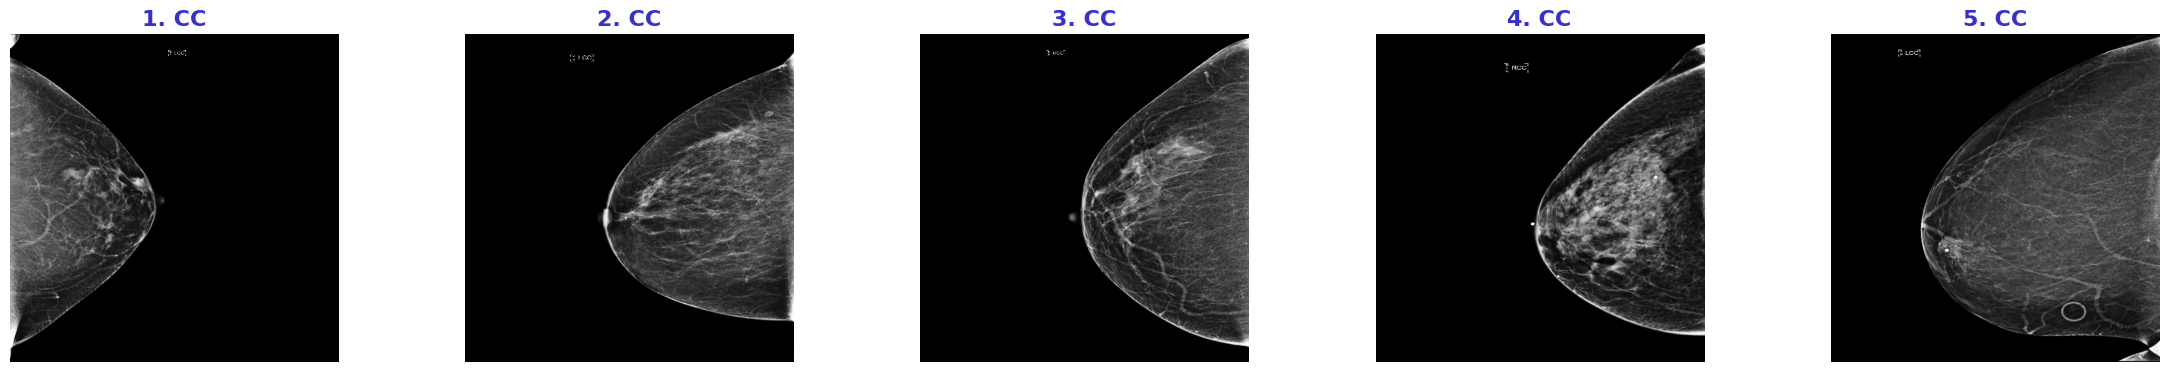

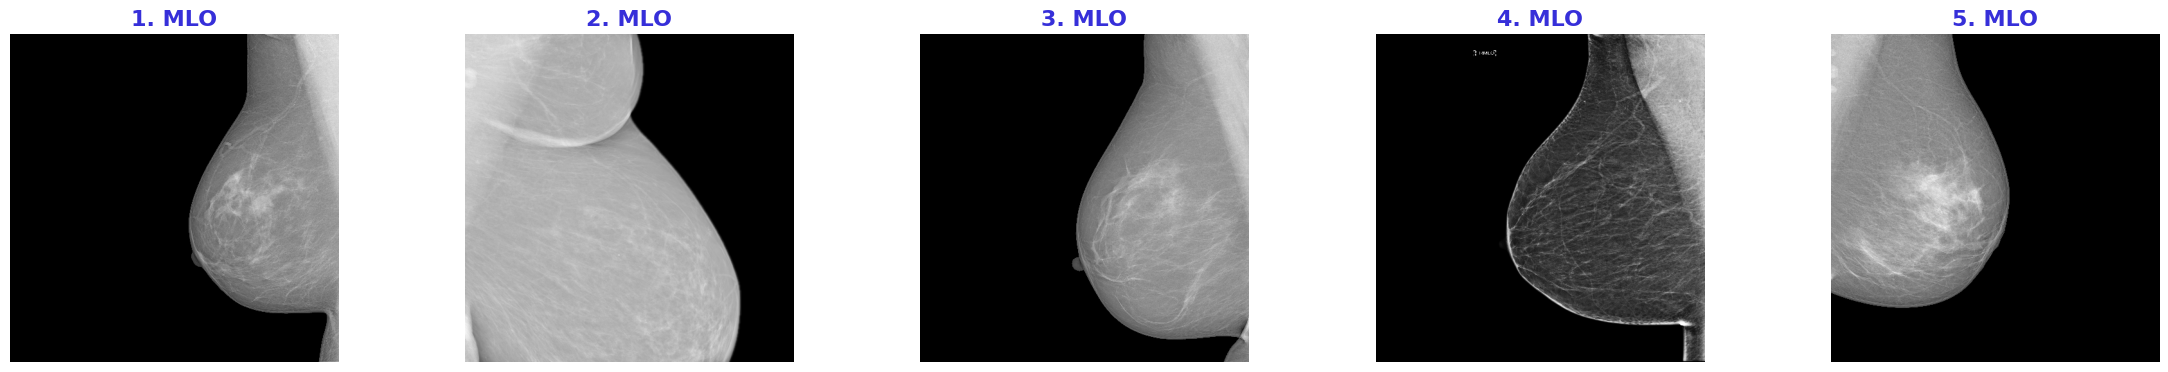

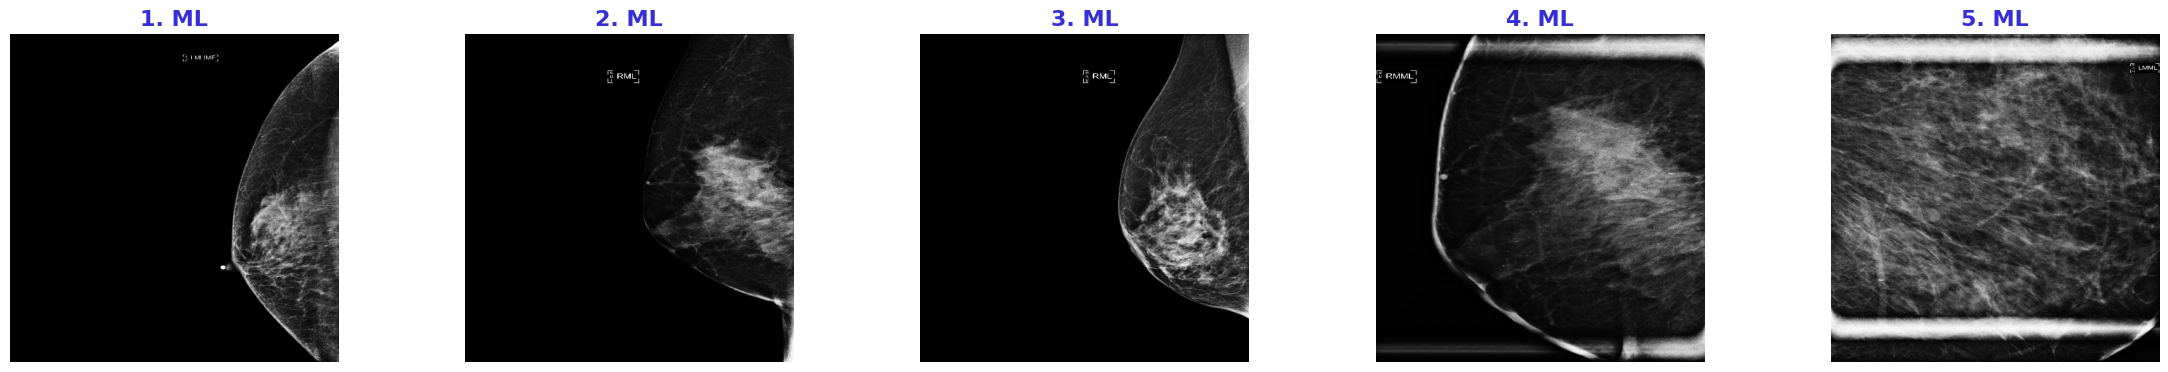

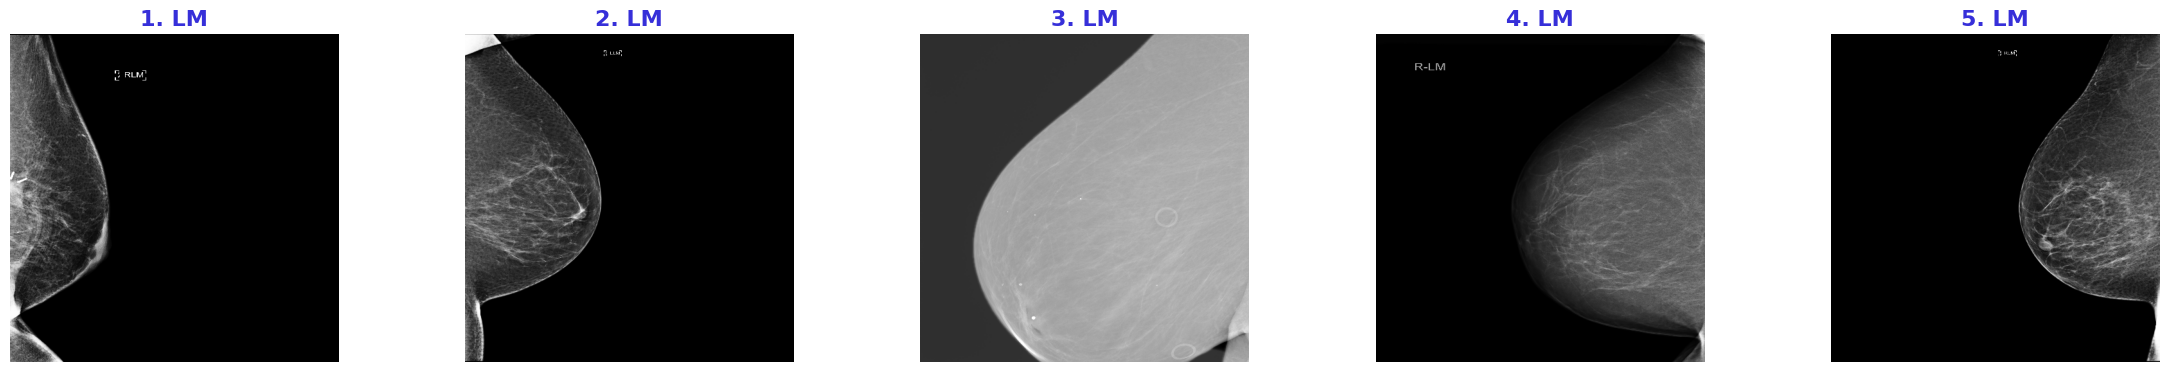

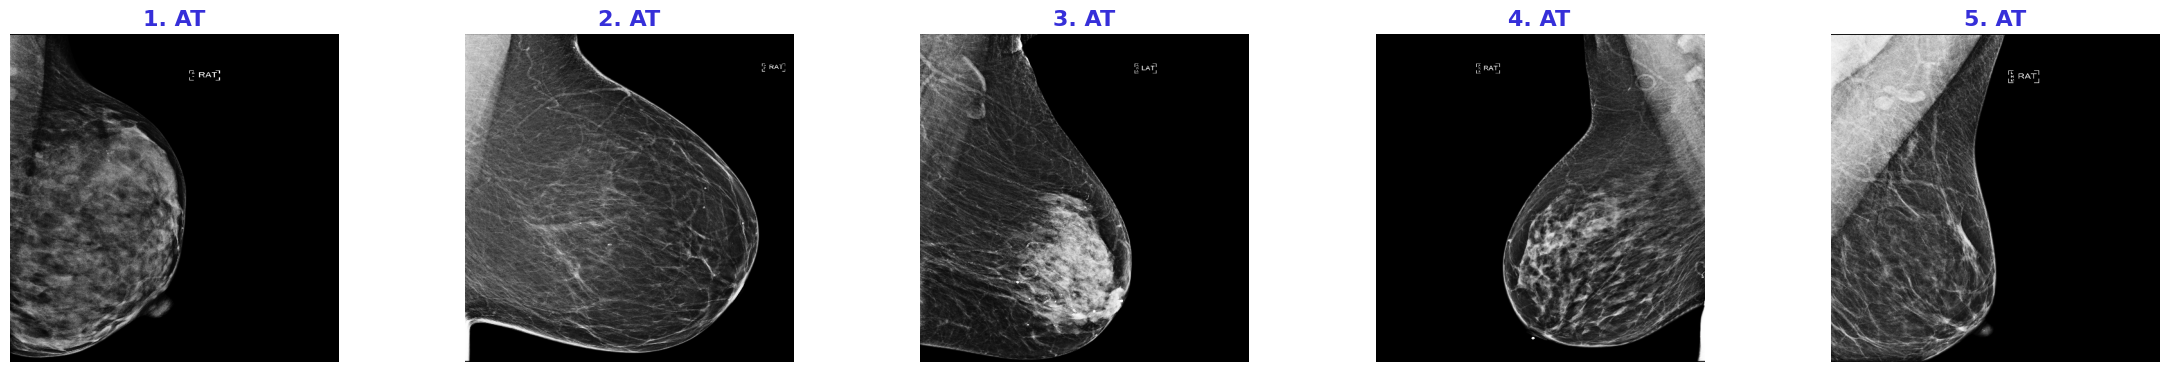

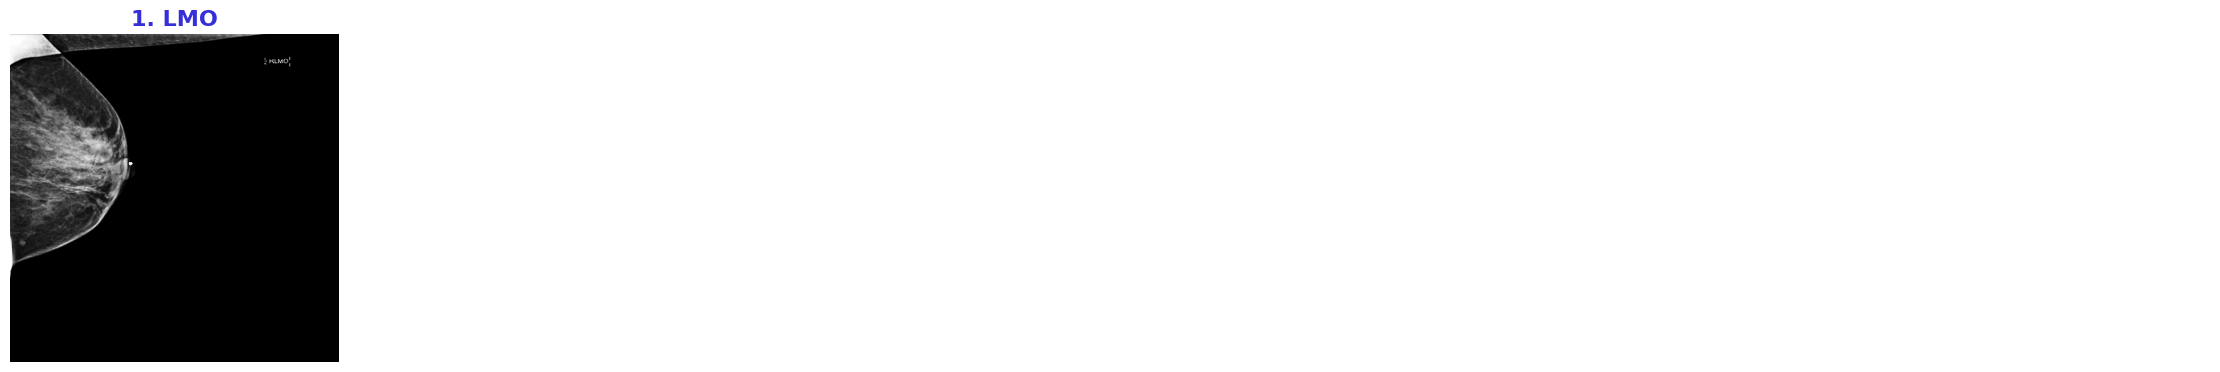

In [10]:
for view_name in train["view"].unique().tolist():
    show_view(view_name, sample_size=5)

In [11]:
wandb.finish()

### 나이별 분포

In [12]:
run = wandb.init(project='RSNA_Breast_Cancer', name='age_hist', config=CONFIG)

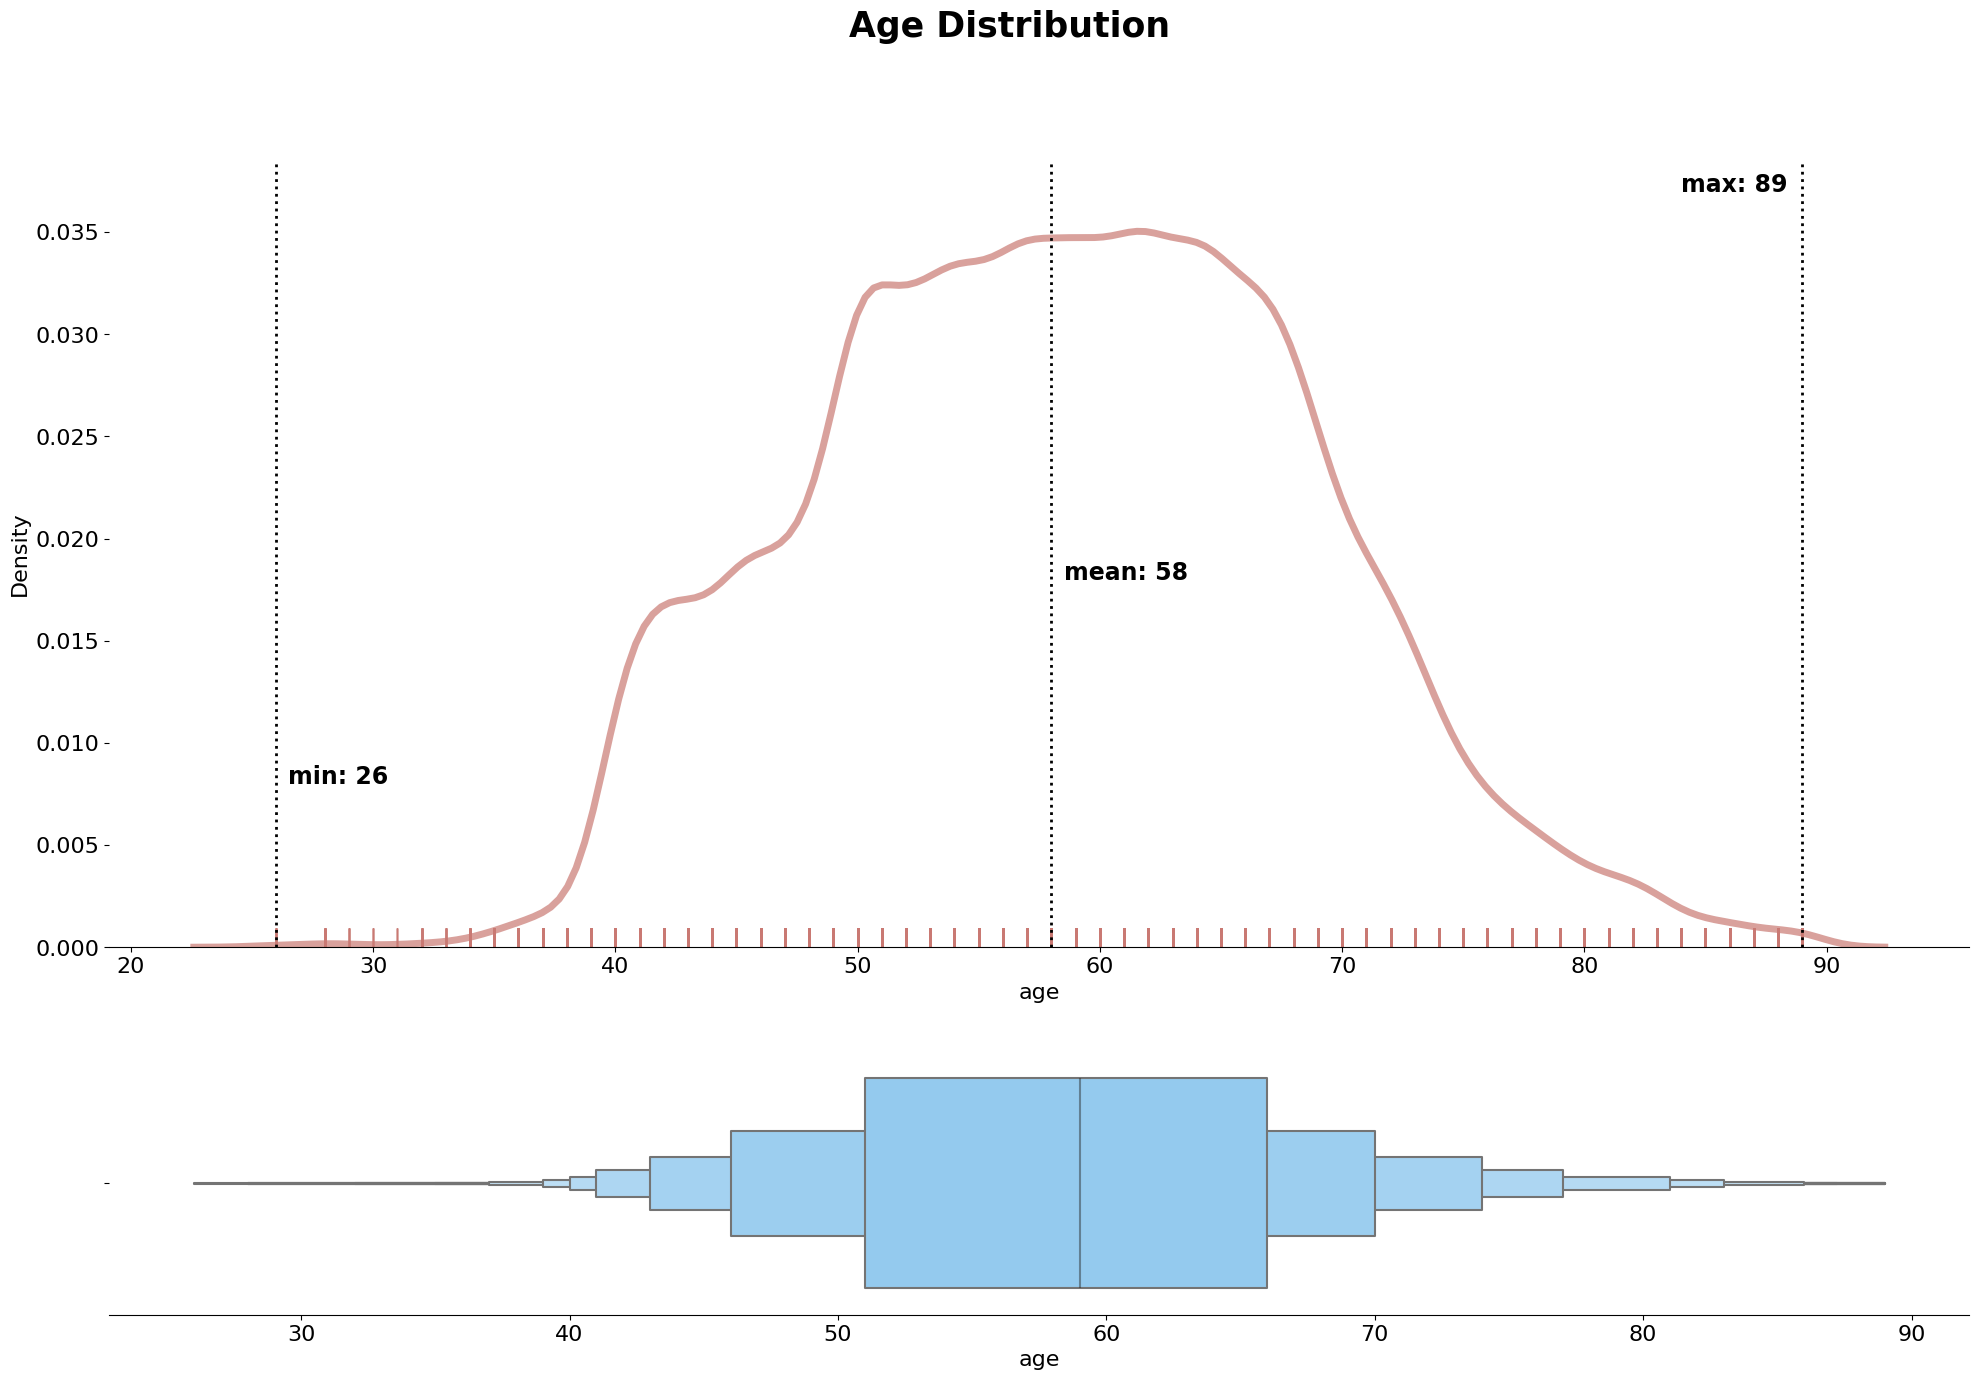

In [13]:
# == Plot ==
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(a=train["age"], rug=True, hist=False, 
             rug_kws={"color": colors[5]},
             kde_kws={"color": colors[5], "lw": 5, "alpha": 0.7},
             ax=a0)

a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=84, y=0.037, s="max: 89", size=17, color="black", weight="bold")

sns.boxenplot(x=train["age"], ax=a1, color=colors[2])

plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [14]:
create_wandb_hist(x_data=train["age"],
                  x_name="Age",
                  title="Age Distribution",
                  log="age_hist")

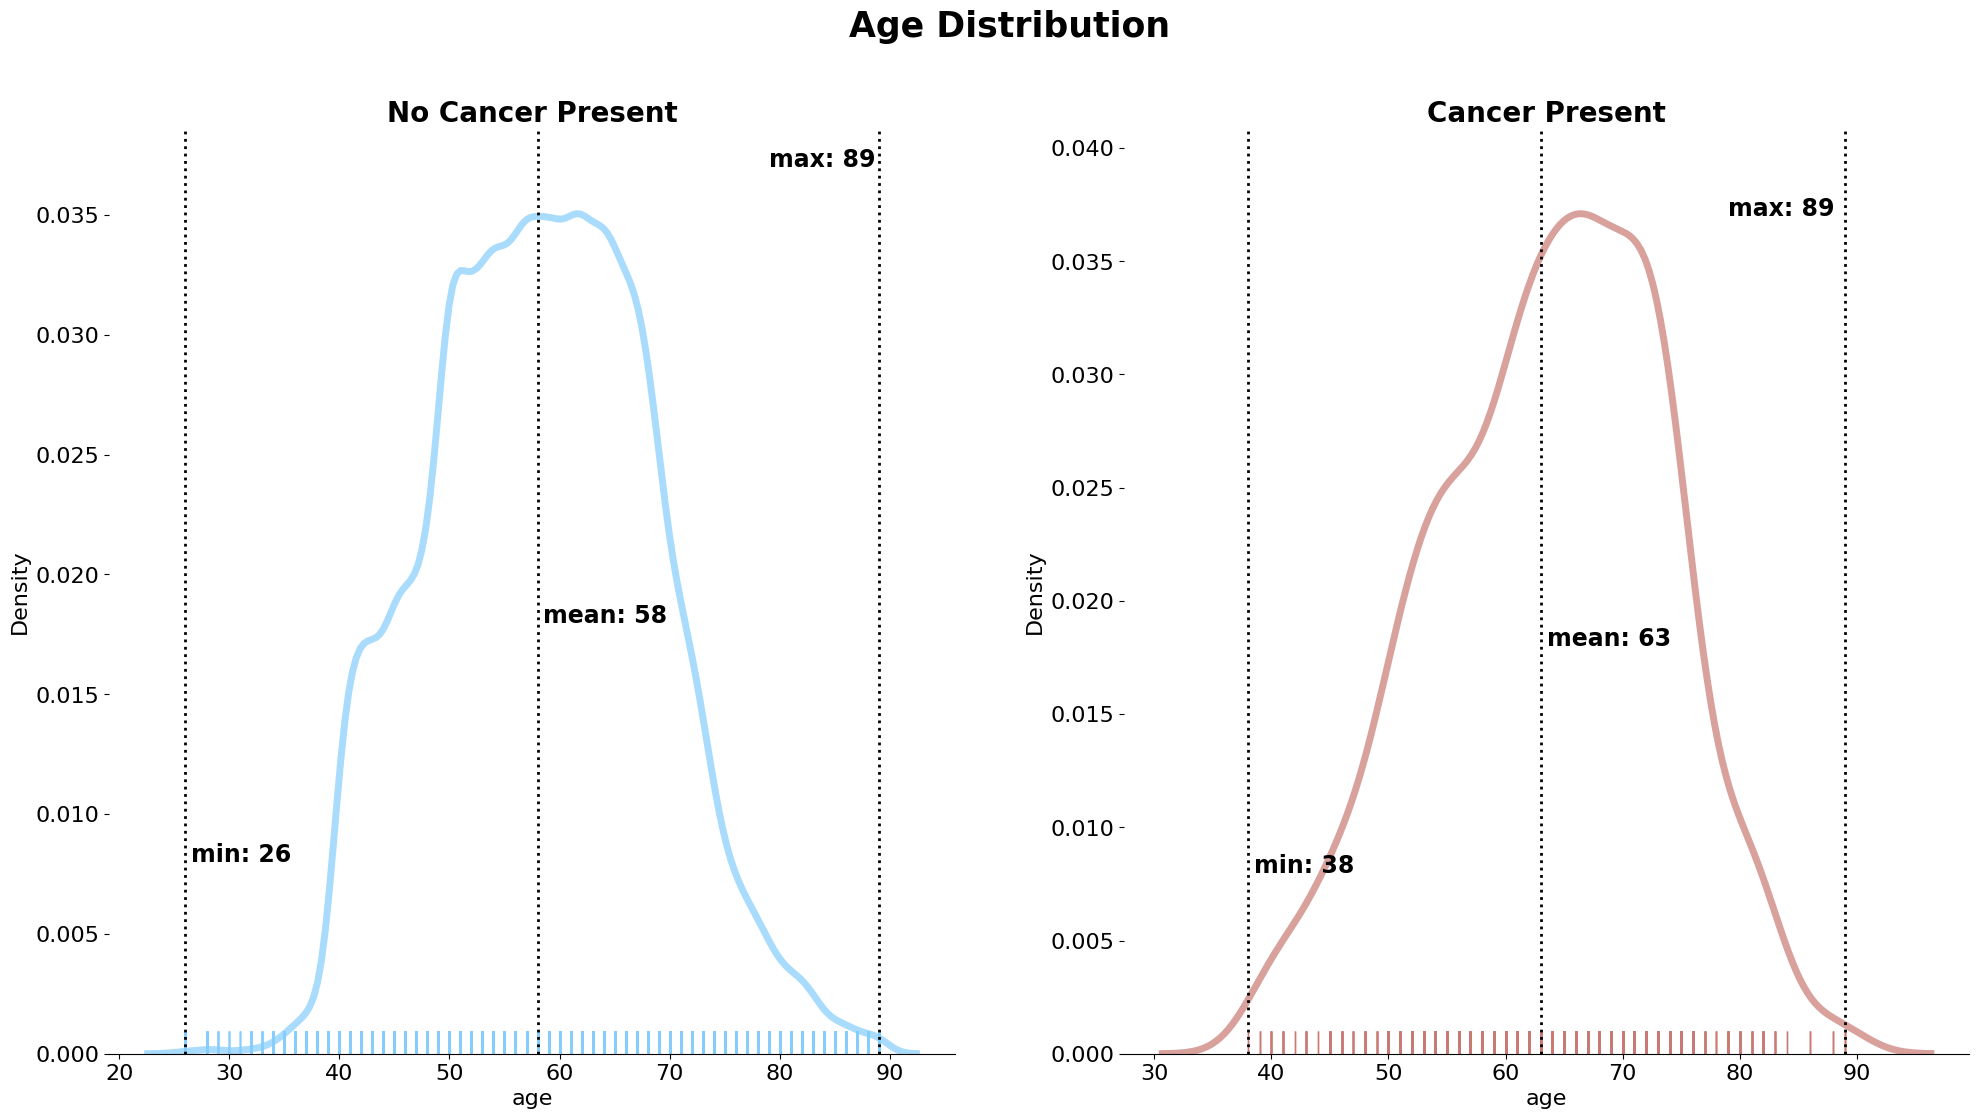

In [15]:
# == Plot ==
f, (a0, a1) = plt.subplots(1, 2, figsize=(24, 12))
sns.distplot(a=train[train["cancer"]==0]["age"], rug=True, hist=False, 
             rug_kws={"color": colors[2]},
             kde_kws={"color": colors[2], "lw": 5, "alpha": 0.7},
             ax=a0)
a0.set_title("No Cancer Present", weight="bold", size=20)
a0.axvline(x=58, ls=":", lw=2, color="black")
a0.text(x=58.5, y=0.018, s="mean: 58", size=17, color="black", weight="bold")
a0.axvline(x=26, ls=":", lw=2, color="black")
a0.text(x=26.5, y=0.008, s="min: 26", size=17, color="black", weight="bold")
a0.axvline(x=89, ls=":", lw=2, color="black")
a0.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


sns.distplot(a=train[train["cancer"]==1]["age"], rug=True, hist=False, 
             rug_kws={"color": colors[5]},
             kde_kws={"color": colors[5], "lw": 5, "alpha": 0.7},
             ax=a1)
a1.set_title("Cancer Present", weight="bold", size=20)
a1.axvline(x=63, ls=":", lw=2, color="black")
a1.text(x=63.5, y=0.018, s="mean: 63", size=17, color="black", weight="bold")
a1.axvline(x=38, ls=":", lw=2, color="black")
a1.text(x=38.5, y=0.008, s="min: 38", size=17, color="black", weight="bold")
a1.axvline(x=89, ls=":", lw=2, color="black")
a1.text(x=79, y=0.037, s="max: 89", size=17, color="black", weight="bold")


plt.suptitle("Age Distribution", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [16]:
features = ["age"]
train[features].describe().T.style.bar(subset=['mean'], color=colors[3])\
    .background_gradient(subset=['std'], cmap='coolwarm')\
    .background_gradient(subset=['50%'], cmap='RdYlBu')

In [17]:
create_wandb_hist(x_data=train[train["cancer"]==1]["age"], 
                  x_name="Age",
                  title="Age Distribution - patients with cancer",
                  log="age_hist_cancer")

In [18]:
wandb.finish()

### 가슴수술 유무

In [19]:
run = wandb.init(project='RSNA_Breast_Cancer', name='implant_sample', config=CONFIG)

In [20]:
def show_images(col, col_flag, sample_size, cancer_flag=0):
    
    # Get image info
    data = train[train[col]==col_flag].sample(sample_size, random_state=24)
    if cancer_flag==1:
        data = train[train.cancer==1]
        data = data[data[col]==col_flag].sample(sample_size, random_state=24)
    image_path = data["path"].to_list()

    # == Plot ==
    fig, axs = plt.subplots(1, sample_size, figsize=(23, 4))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(image_path):
        axs[k].set_title(f"{k+1}. {col_flag}", 
                         fontsize = 14, color = colors[0], weight='bold')

        img = cv2.imread(path)
        wandb_images.append(wandb.Image(img))
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

    wandb.log({f"{col}_{col_flag}": wandb_images})

Records with no implants: 53229 
Records with implants: 1477 



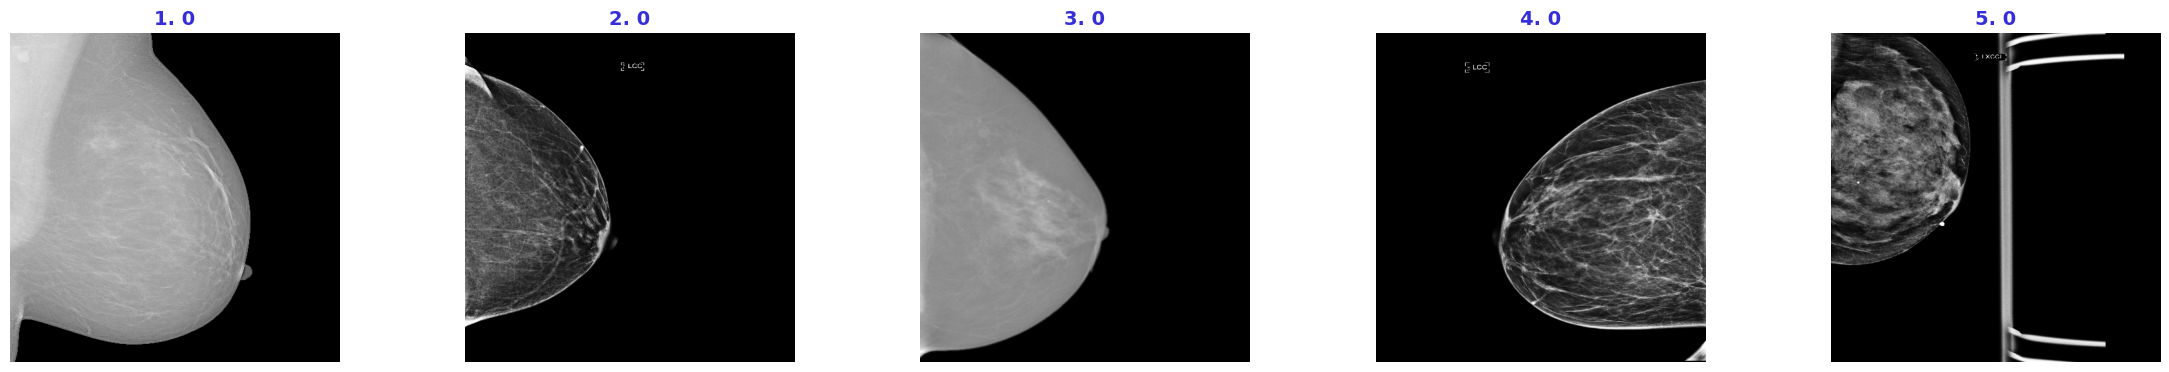

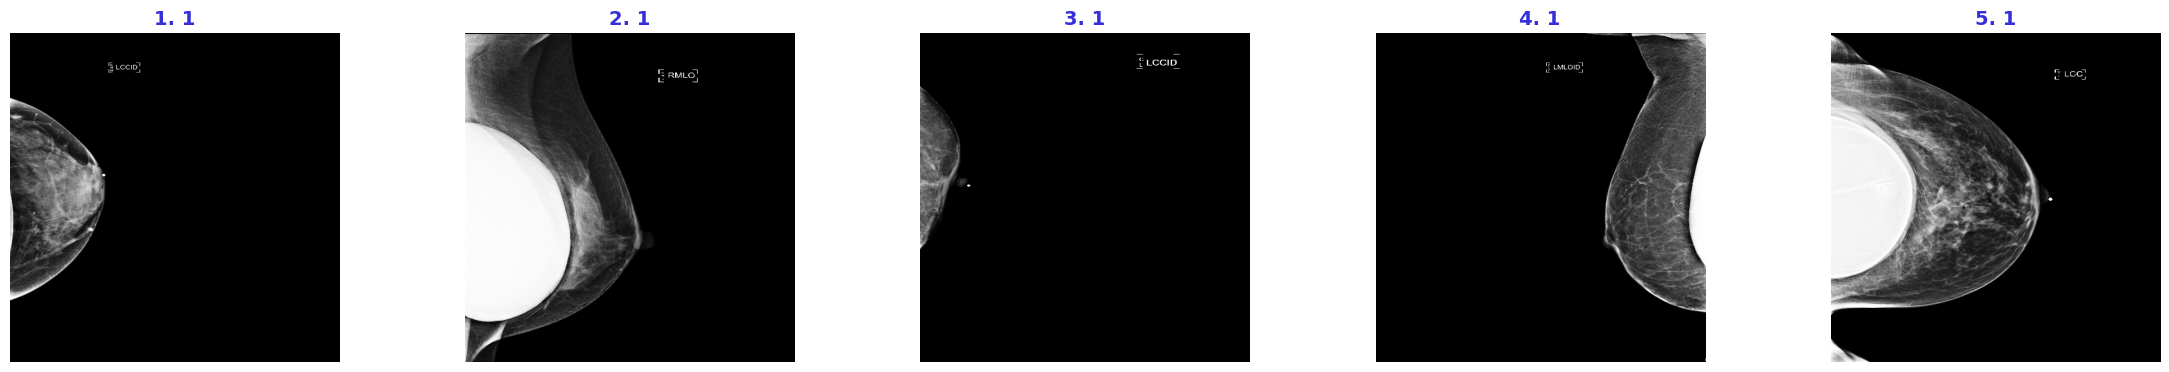

In [21]:
print(clr.S+"Records with no implants:"+clr.E, train["implant"].value_counts().values[0], "\n"+
      clr.S+"Records with implants:"+clr.E, train["implant"].value_counts().values[1], "\n")

for implant_flag in train["implant"].unique().tolist():
    show_images(col="implant", col_flag=implant_flag, sample_size=5)

In [22]:
wandb.finish()

In [23]:
run = wandb.init(project='RSNA_Breast_Cancer', name='cancer_explore', config=CONFIG)

### 암 유무

Records with no cancer: 53548 
Records with cancer: 1158 



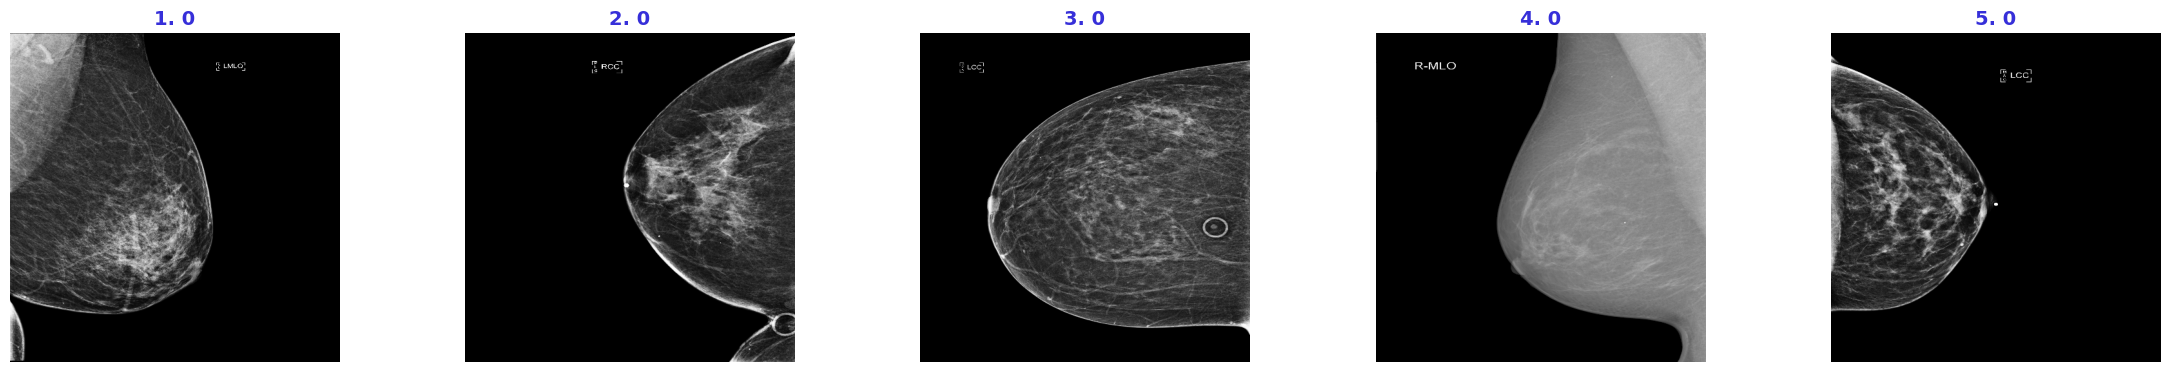

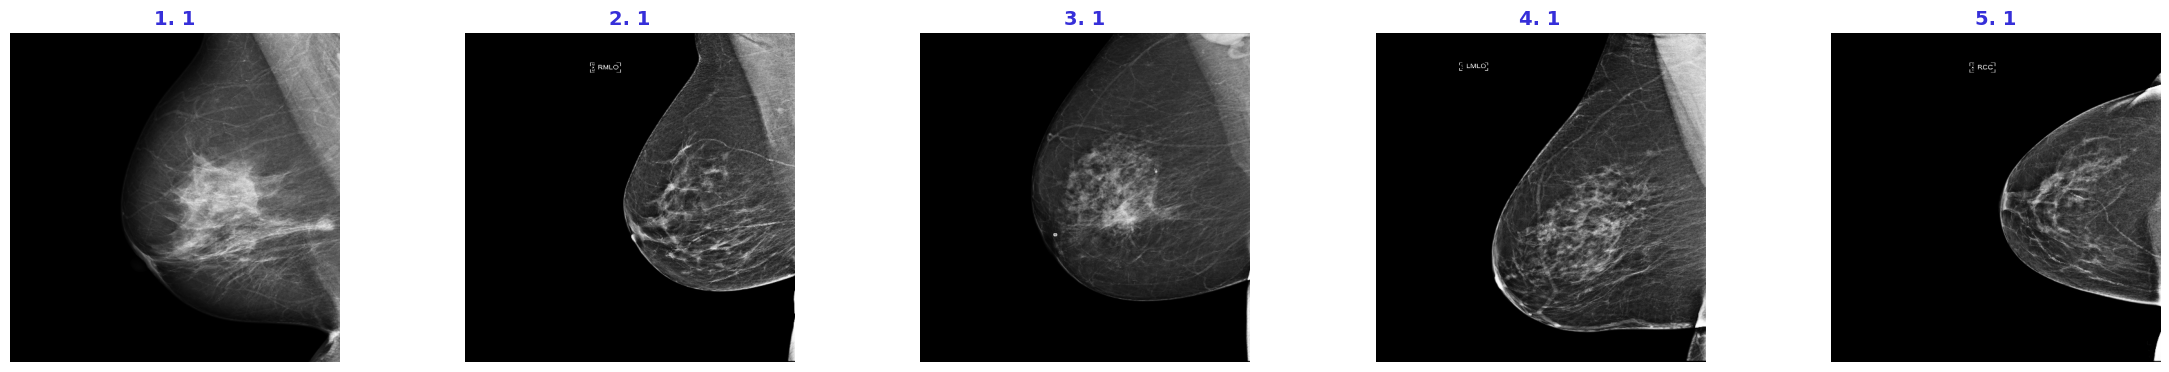

In [24]:
print(clr.S+"Records with no cancer:"+clr.E, train["cancer"].value_counts().values[0], "\n"+
      clr.S+"Records with cancer:"+clr.E, train["cancer"].value_counts().values[1], "\n")

for cancer_flag in train["cancer"].unique().tolist():
    show_images(col="cancer", col_flag=cancer_flag, sample_size=5)

### 침윤성/비침윤성 여부
- 유방암이 양성인 경우에 침윤성으로 판명되었는지 여부

Records with invasion: 818 
Records with no invasion: 340 



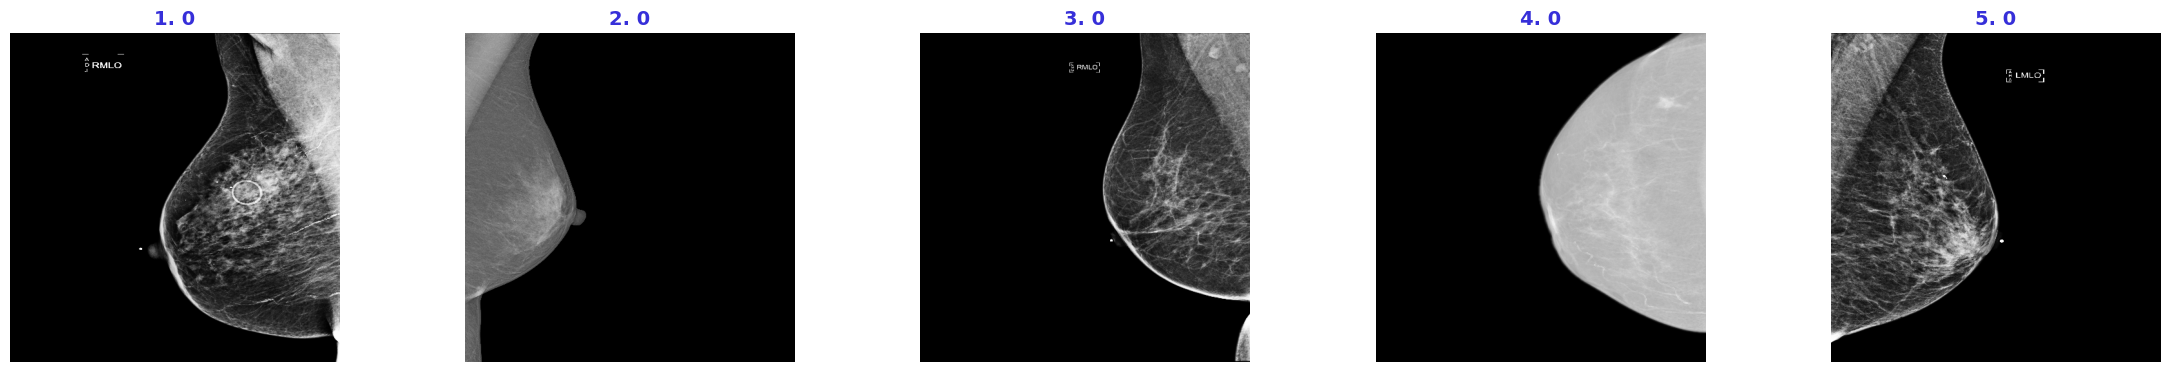

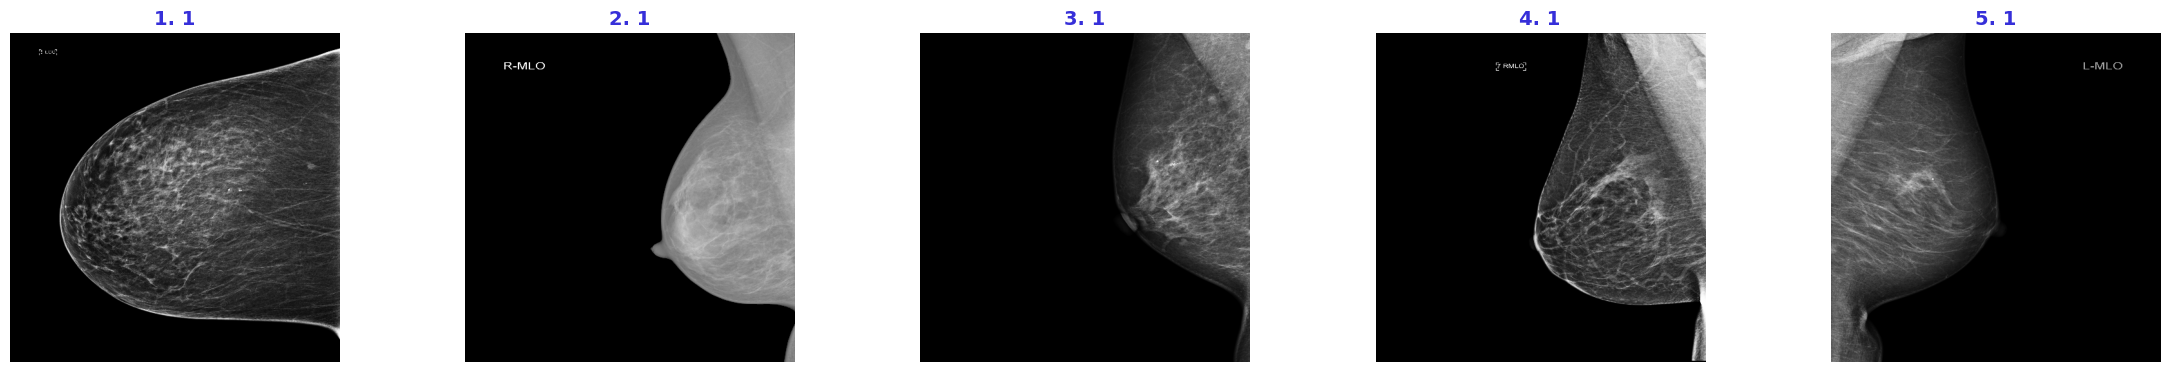

In [25]:
print(clr.S+"Records with invasion:"+clr.E, train[train.cancer==1]["invasive"].value_counts().values[0], "\n"+
      clr.S+"Records with no invasion:"+clr.E, train[train.cancer==1]["invasive"].value_counts().values[1], "\n")

for invasive_flag in train["invasive"].unique().tolist():
    show_images(col="invasive", col_flag=invasive_flag, sample_size=5, cancer_flag=1)

### 케이스가 비정상적으로 어려운 경우

Cases not particularly difficult: 47001 
Cases particularly difficult: 7705 



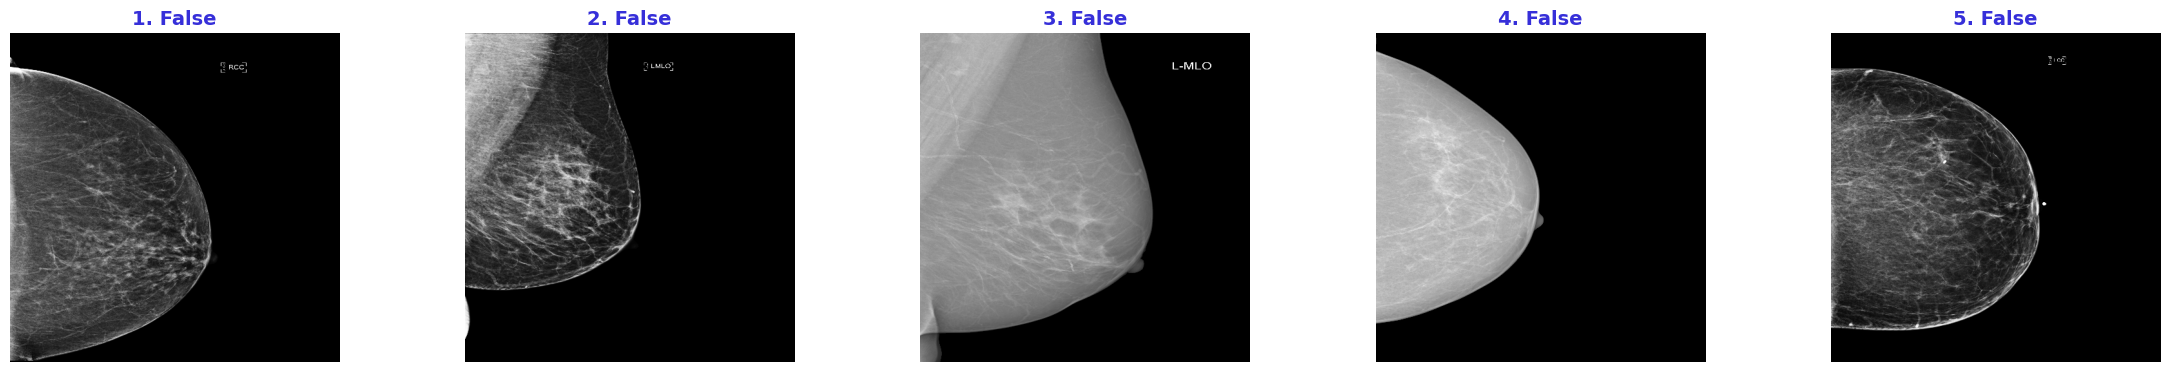

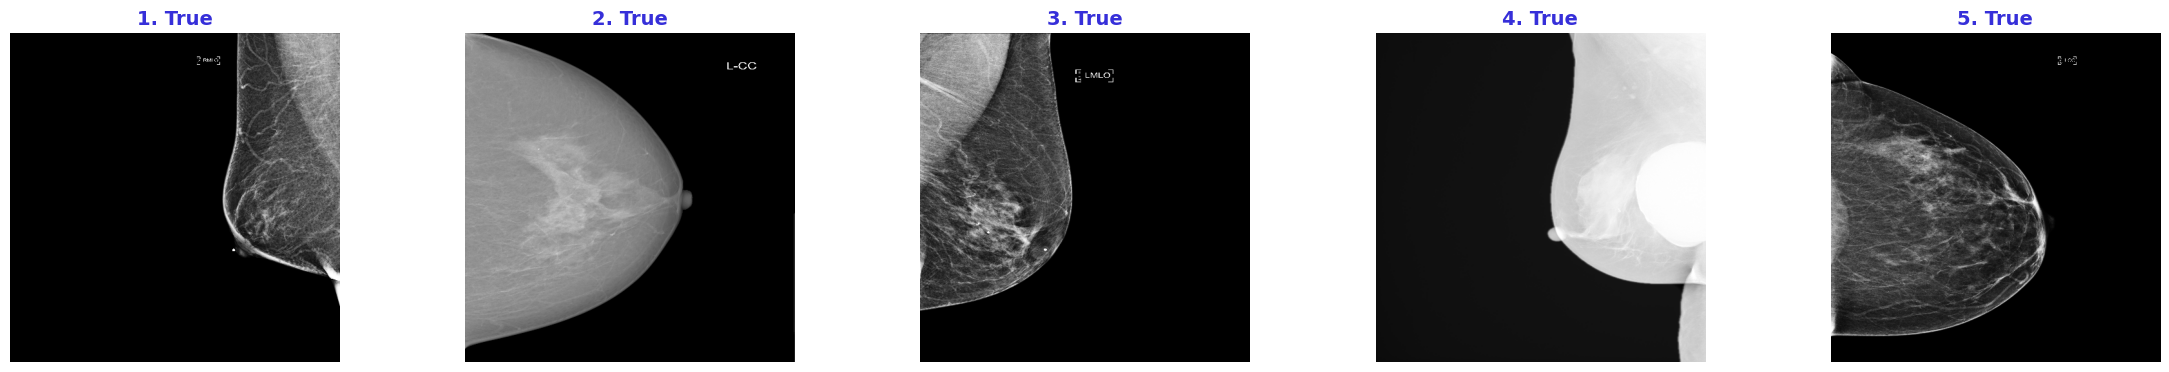

In [26]:
print(clr.S+"Cases not particularly difficult:"+clr.E, train["difficult_negative_case"].value_counts().values[0], "\n"+
      clr.S+"Cases particularly difficult:"+clr.E, train["difficult_negative_case"].value_counts().values[1], "\n")

for difficult_flag in train["difficult_negative_case"].unique().tolist():
    show_images(col="difficult_negative_case", col_flag=difficult_flag, sample_size=5, cancer_flag=0)

In [27]:
wandb.finish()